<div style="display:block" direction=rtl align=right><br><br>
    <div  style="width:100%;margin:100;display:block"  display=block align=center>
        <img width=130 align=right src="https://i.ibb.co/yXKQmtZ/logo1.png" style="margin:0;" />
        <img width=170 align=left  src="https://i.ibb.co/wLjqFkw/logo2.png" style="margin:0;" />
        <span><br><font size=5>University of Tehran , school of ECE</font></span>
        <span><br><font size=3>Deep Generative Models Course</font></span>
        <span><br><font size=3>Fall 2022</font></span>
    </div><br><br><br>
    <div style="display:block" align=left display=block>
        <font size=3>Homework 3</font><br>
        <hr />
        <font size=3>TA: <a href="mailto:p.zilouchian@ut.ac.ir">Parham Zilouchian</a><br></font><br>
    </div>
</div>

# **Part1: Diffusion Models and Latent Diffusion**



In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Dec  4 01:48:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    29W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Section 1: Overview of Diffusion Models

Let's begin by seeing where diffusion models fit within the zoo of generative models in use today:

![model type diag](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/generative-overview.png)
Overview of different types of generative models. (from [this great blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/))

The core concept behind these models is deceptively simple:
- Take a starting image
- Add some noise, iteratively degrading the image until almost nothing but noise remains.
- Train a model to 'undo' these noise steps.
- To generate, start from pure noise and repeatedly apply the model to 'denoise' our way back to a plausible image.

The model generally has access to some representation of 't' - that is, how many noise steps have been applied to the image. And to make its job easier, we typically get the model to output a prediction for the *noise* that we could subtract from the noisy image to get a less noisy one, rather than spitting out the denoised image.

With this high-level idea in our heads, let's have a go at implementing one!


# Section 2: Implementing One



In [1]:
# @title Install requirements
!pip install datasets &>> install.log

In [2]:
#@title imports and utility functions
from datasets import load_dataset
from PIL import Image
import torch.nn.functional as F
import os
from tqdm.notebook import tqdm
import torch
import numpy as np


def img_to_tensor(im):
  return torch.tensor(np.array(im.convert('RGB'))/255).permute(2, 0, 1).unsqueeze(0) * 2 - 1

def tensor_to_image(t):
  return Image.fromarray(np.array(((t.squeeze().permute(1, 2, 0)+1)/2).clip(0, 1)*255).astype(np.uint8))

def gather(consts: torch.Tensor, t: torch.Tensor):
    """Gather consts for $t$ and reshape to feature map shape"""
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)

## 2.1 Dataset

We'll start with a classic small dataset, with 32px square images from 10 classes. For convenience we just pull a version that is avalable on the huggingface hub.

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

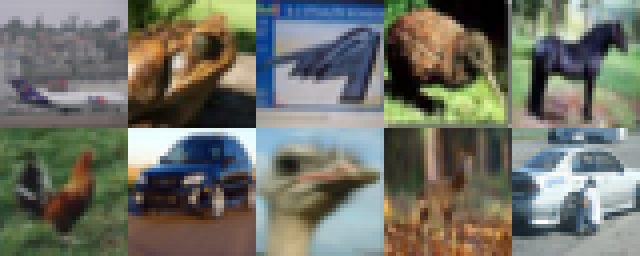

In [3]:
#@title cifar10 - 32px images in 10 classes

# Download and load the dataset
cifar10 = load_dataset('cifar10')

# View some examples:
image = Image.new('RGB', size=(32*5, 32*2))
for i in range(10):
  im = cifar10['train'][i]['img']
  image.paste(im, ( (i%5)*32, (i//5)*32 ))
image.resize((32*5*4, 32*2*4), Image.NEAREST)

In [4]:
# @title alternative dataset: faces (CelebA) - uncomment to run
# faces = load_dataset('huggan/CelebA-faces')

## 2.2 Adding Noise

First, we want to define the spet that adds a little bit of noise - $q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$:

![process](https://datasciencecastnethome.files.wordpress.com/2022/04/screenshot-from-2022-04-12-14-55-09.png) [(Image source)](https://hojonathanho.github.io/diffusion/)

We set up a 'variance schedule' β, where beta[t] ($\beta_t$)specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. The formula you'll see for this single noise step is:

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$

We mix $\mathbf{x}_{t-1}$ with some gaussian noise, with how much noise decided by $\beta_t$. Let's see this in code and try applying it a bunch of times to an image:

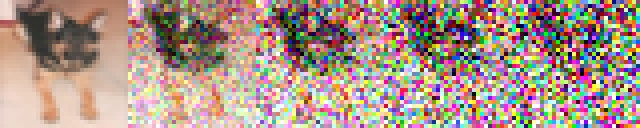

In [5]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)


  ################################################################################

def q_xt_xtminus1(xtm1, t):
    # Parameters
    sqrt_one_minus_beta_t = (1. - beta[t]) ** 0.5
    sqrt_beta_t = beta[t] ** 0.5

    # Compute mean and variance
    mean = sqrt_one_minus_beta_t * xtm1  # sqrt(1−beta*t)*xtm1
    var = sqrt_beta_t  # 1−beta*t I

    # Generate noise shaped like xtm1
    eps = torch.randn_like(xtm1)

    # Combine mean and noise to get the final result
    result = mean + (var * eps)

    return result


    ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

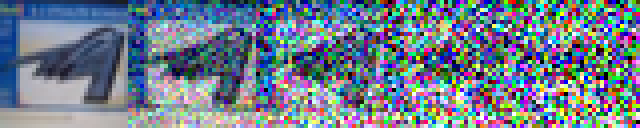

In [6]:
# Show im at different stages
ims = []
start_im = cifar10['train'][2]['img']
x = img_to_tensor(start_im).squeeze()
for t in range(n_steps):

  # Store images every 20 steps to show progression
  if t%20 == 0:
    ims.append(tensor_to_image(x))

  # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
  t = torch.tensor(t, dtype=torch.long) # t as a tensor
  x = q_xt_xtminus1(x, t) # Modify x using our function above

# Display the images
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Now, we want to train our model at different time steps and we don't particulary want to iterativly add little bits of noise a bunch of times just to train one sample from t=37.

Luckily, some smart people did some fancy maths (link https://lilianweng.github.io/posts/2018-08-12-vae/#reparameterization-trick) using something called the reparameterization trick that lets us get $x_t$ for any t given $x_0$.

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$


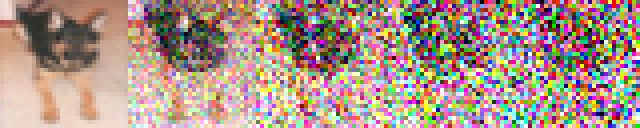

In [7]:
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

  ################################################################################

def q_xt_x0(x0, t):

    # Parameters
    sqrt_alpha_bar_t = alpha_bar[t] ** 0.5
    one_minus_alpha_bar_t = 1. - alpha_bar[t]

    # Compute mean and variance
    mean = sqrt_alpha_bar_t * x0  # now alpha_bar
    var = one_minus_alpha_bar_t  # (1-alpha_bar)

    # Generate noise shaped like x0
    eps = torch.randn_like(x0)

    # Combine mean and noise to get the final result
    result = mean + (var ** 0.5) * eps

    return result



    ################################################################################

# Show im at different stages
ims = []
start_im = cifar10['train'][10]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

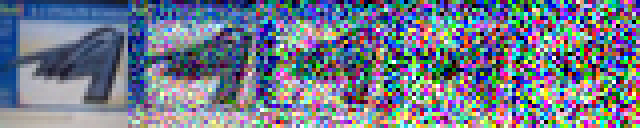

In [8]:
# Show im at different stages
ims = []
start_im = cifar10['train'][2]['img']
x0 = img_to_tensor(start_im).squeeze()
for t in [0, 20, 40, 60, 80]:
  x = q_xt_x0(x0, torch.tensor(t, dtype=torch.long)) # TODO move type to gather
  ims.append(tensor_to_image(x))

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Note the difference: we can now calculate xt without having to do `for t in range...`.

## 2.3 UNETs

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

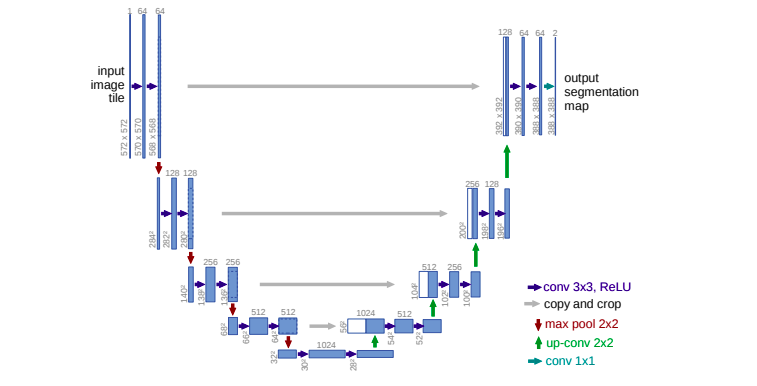

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization ([deoldify](https://github.com/jantic/DeOldify)), segmentation and so on. These days, typical unet models incorporate ideas such as attention (it's all you need!) and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below (taken almost verbatim from [here](https://github.com/labmlai/annotated_deep_learning_paper_implementations/blob/master/labml_nn/diffusion/ddpm/unet.py)) is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [15]:
#@title Unet Definition

import math
from typing import Optional, Tuple, Union, List

import torch
from torch import nn

# A fancy activation function
class Swish(nn.Module):
    """
    ### Swish actiavation function
    $$x \cdot \sigma(x)$$
    """

    def forward(self, x):
        return x * torch.sigmoid(x)

# The time embedding
class TimeEmbedding(nn.Module):
    """
    ### Embeddings for $t$
    """

    def __init__(self, n_channels: int):
        """
        * `n_channels` is the number of dimensions in the embedding
        """
        super().__init__()
        self.n_channels = n_channels
        # First linear layer
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        # Activation
        self.act = Swish()
        # Second linear layer
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        # Create sinusoidal position embeddings

        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        # Transform with the MLP
        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        #
        return emb

# Residual blocks include 'skip' connections
class ResidualBlock(nn.Module):
    """
    ### Residual block
    A residual block has two convolution layers with group normalization.
    Each resolution is processed with two residual blocks.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, n_groups: int = 32):
        """
        * `in_channels` is the number of input channels
        * `out_channels` is the number of input channels
        * `time_channels` is the number channels in the time step ($t$) embeddings
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()
        # Group normalization and the first convolution layer
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # Group normalization and the second convolution layer
        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        # Linear layer for time embeddings
        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # First convolution layer
        h = self.conv1(self.act1(self.norm1(x)))
        # Add time embeddings
        h += self.time_emb(t)[:, :, None, None]
        # Second convolution layer
        h = self.conv2(self.act2(self.norm2(h)))

        # Add the shortcut connection and return
        return h + self.shortcut(x)

# Ahh yes, magical attention...
class AttentionBlock(nn.Module):
    """
    ### Attention block
    This is similar to [transformer multi-head attention](../../transformers/mha.html).
    """

    def __init__(self, n_channels: int, n_heads: int = 1, d_k: int = None, n_groups: int = 32):
        """
        * `n_channels` is the number of channels in the input
        * `n_heads` is the number of heads in multi-head attention
        * `d_k` is the number of dimensions in each head
        * `n_groups` is the number of groups for [group normalization](../../normalization/group_norm/index.html)
        """
        super().__init__()

        # Default `d_k`
        if d_k is None:
            d_k = n_channels
        # Normalization layer
        self.norm = nn.GroupNorm(n_groups, n_channels)
        # Projections for query, key and values
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        # Linear layer for final transformation
        self.output = nn.Linear(n_heads * d_k, n_channels)
        # Scale for dot-product attention
        self.scale = d_k ** -0.5
        #
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x: torch.Tensor, t: Optional[torch.Tensor] = None):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size, time_channels]`
        """
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        # Get shape
        batch_size, n_channels, height, width = x.shape
        # Change `x` to shape `[batch_size, seq, n_channels]`
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        # Get query, key, and values (concatenated) and shape it to `[batch_size, seq, n_heads, 3 * d_k]`
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        # Split query, key, and values. Each of them will have shape `[batch_size, seq, n_heads, d_k]`
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        # Calculate scaled dot-product $\frac{Q K^\top}{\sqrt{d_k}}$
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        # Softmax along the sequence dimension $\underset{seq}{softmax}\Bigg(\frac{Q K^\top}{\sqrt{d_k}}\Bigg)$
        attn = attn.softmax(dim=1)
        # Multiply by values
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        # Reshape to `[batch_size, seq, n_heads * d_k]`
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        # Transform to `[batch_size, seq, n_channels]`
        res = self.output(res)

        # Add skip connection
        res += x

        # Change to shape `[batch_size, in_channels, height, width]`
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        #
        return res


class DownBlock(nn.Module):
    """
    ### Down block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the first half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    """
    ### Up block
    This combines `ResidualBlock` and `AttentionBlock`. These are used in the second half of U-Net at each resolution.
    """

    def __init__(self, in_channels: int, out_channels: int, time_channels: int, has_attn: bool):
        super().__init__()
        # The input has `in_channels + out_channels` because we concatenate the output of the same resolution
        # from the first half of the U-Net
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    """
    ### Middle block
    It combines a `ResidualBlock`, `AttentionBlock`, followed by another `ResidualBlock`.
    This block is applied at the lowest resolution of the U-Net.
    """

    def __init__(self, n_channels: int, time_channels: int):
        super().__init__()
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    """
    ### Scale up the feature map by $2 \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    """
    ### Scale down the feature map by $\frac{1}{2} \times$
    """

    def __init__(self, n_channels):
        super().__init__()
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # `t` is not used, but it's kept in the arguments because for the attention layer function signature
        # to match with `ResidualBlock`.
        _ = t
        return self.conv(x)

# The core class definition (aka the important bit)
class UNet(nn.Module):
    """
    ## U-Net
    """

    def __init__(self, image_channels: int = 3, n_channels: int = 64,
                 ch_mults: Union[Tuple[int, ...], List[int]] = (1, 2, 2, 4),
                 is_attn: Union[Tuple[bool, ...], List[int]] = (False, False, True, True),
                 n_blocks: int = 2):
        """
        * `image_channels` is the number of channels in the image. $3$ for RGB.
        * `n_channels` is number of channels in the initial feature map that we transform the image into
        * `ch_mults` is the list of channel numbers at each resolution. The number of channels is `ch_mults[i] * n_channels`
        * `is_attn` is a list of booleans that indicate whether to use attention at each resolution
        * `n_blocks` is the number of `UpDownBlocks` at each resolution
        """
        super().__init__()

        # Number of resolutions
        n_resolutions = len(ch_mults)

        # Project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # Time embedding layer. Time embedding has `n_channels * 4` channels
        self.time_emb = TimeEmbedding(n_channels * 4)

        # #### First half of U-Net - decreasing resolution
        down = []
        # Number of channels
        out_channels = in_channels = n_channels
        # For each resolution
        for i in range(n_resolutions):
            # Number of output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            # Add `n_blocks`
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            # Down sample at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # Combine the set of modules
        self.down = nn.ModuleList(down)

        # Middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # #### Second half of U-Net - increasing resolution
        up = []
        # Number of channels
        in_channels = out_channels
        # For each resolution
        for i in reversed(range(n_resolutions)):
            # `n_blocks` at the same resolution
            out_channels = in_channels
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            # Final block to reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            # Up sample at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        # Combine the set of modules
        self.up = nn.ModuleList(up)

        # Final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x: torch.Tensor, t: torch.Tensor):
        """
        * `x` has shape `[batch_size, in_channels, height, width]`
        * `t` has shape `[batch_size]`
        """

        # Get time-step embeddings
        t = self.time_emb(t)

        # Get image projection
        x = self.image_proj(x)

        # `h` will store outputs at each resolution for skip connection
        h = [x]
        # First half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # Middle (bottom)
        x = self.middle(x, t)

        # Second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
            else:
                # Get the skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                #
                x = m(x, t)

        # Final normalization and convolution
        return self.final(self.act(self.norm(x)))

In [16]:
# Let's see it in action on dummy data:

# A dummy batch of 10 3-channel 32px images
x = torch.randn(10, 3, 32, 32)

# 't' - what timestep are we on
t = torch.tensor([50.], dtype=torch.long)

# Define the unet model
unet = UNet()

# The foreward pass (takes both x and t)
model_output = unet(x, t)

# The output shape matches the input.
model_output.shape

torch.Size([10, 3, 32, 32])

## 2.4 Training Time

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

Why not predict the denoised image directly? Mostly just due to convenience - the noise is nicely scaled with a mean of zero, and this well-suited to being modeled with a neural network. You don't **have** to do it this way, but the papers do, and we can make it easy by tweaking our `q_xt_x0` function to return both the noised image ($x_t$) and the noise itself, which will be the 'target' our network tries to produce.

This training loop should look familiar from all the past lessons!

In [37]:
# Create the model
unet = UNet(n_channels=32).cuda()

# Set up some parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps).cuda()
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)


# def q_xt_x0(x0, t):
#     # Parameters
#     sqrt_alpha_bar_t = alpha_bar[t] ** 0.5
#     one_minus_alpha_bar_t = 1. - alpha_bar[t]
#     # Compute mean and variance
#     mean = sqrt_alpha_bar_t * x0  # now alpha_bar
#     var = one_minus_alpha_bar_t  # (1-alpha_bar)
#     # Generate noise shaped like x0
#     eps = torch.randn_like(x0).to(x0.device)
#     # Combine mean and noise to get the final result
#     result = mean + (var ** 0.5) * eps
#     return result , eps


def q_xt_x0(x0, t):
    # Extract alpha_bar values at indices specified by t
    sqrt_alpha_bar_t = torch.sqrt(torch.index_select(alpha_bar, 0, t))

    # Compute mean and variance
    mean = sqrt_alpha_bar_t.view(-1, 1, 1, 1) * x0
    var = 1 - torch.index_select(alpha_bar, 0, t)

    # Generate noise shaped like x0
    eps = torch.randn_like(x0).to(x0.device)

    # Combine mean and noise to get the final result
    result = mean + torch.sqrt(var).view(-1, 1, 1, 1) * eps

    return result, eps


# Training params
batch_size = 128
lr = 2e-4
num_epochs = 20
# Set up optimizer
optimizer = torch.optim.AdamW(unet.parameters(), lr=lr)

In [38]:
# Training Loop

# Loss function container
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training phase
    unet.train()
    epoch_train_losses = []
    for i in tqdm(range(0, len(cifar10['train']) - batch_size, batch_size)):
        ims = [cifar10['train'][idx]['img'] for idx in range(i, i + batch_size)]
        tims = [img_to_tensor(im).cuda() for im in ims]
        x0 = torch.cat(tims)
        t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda()
        xt, noise = q_xt_x0(x0, t)
        pred_noise = unet(xt.float(), t)
        loss = F.mse_loss(noise.float(), pred_noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_losses.append(loss.item())

    # Validation phase
    unet.eval()
    epoch_val_losses = []
    with torch.no_grad():
        for i in tqdm(range(0, len(cifar10['test']) - batch_size, batch_size)):
            ims_val = [cifar10['test'][idx]['img'] for idx in range(i, i + batch_size)]
            tims_val = [img_to_tensor(im).cuda() for im in ims_val]
            x0_val = torch.cat(tims_val)
            t_val = torch.randint(0, n_steps, (batch_size,), dtype=torch.long).cuda()
            xt_val, noise_val = q_xt_x0(x0_val, t_val)
            pred_noise_val = unet(xt_val.float(), t_val)
            loss_val = F.mse_loss(noise_val.float(), pred_noise_val)
            epoch_val_losses.append(loss_val.item())


    # Calculate average losses for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)

    # Append losses to the lists
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print or log the losses for monitoring
    print(f'Epoch {epoch + 1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 1/20: Train Loss: 0.2031, Val Loss: 0.1203


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 2/20: Train Loss: 0.1103, Val Loss: 0.0992


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 3/20: Train Loss: 0.0959, Val Loss: 0.0926


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 4/20: Train Loss: 0.0892, Val Loss: 0.0860


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 5/20: Train Loss: 0.0855, Val Loss: 0.0882


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 6/20: Train Loss: 0.0829, Val Loss: 0.0825


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 7/20: Train Loss: 0.0815, Val Loss: 0.0815


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 8/20: Train Loss: 0.0803, Val Loss: 0.0785


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 9/20: Train Loss: 0.0791, Val Loss: 0.0785


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 10/20: Train Loss: 0.0786, Val Loss: 0.0762


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 11/20: Train Loss: 0.0781, Val Loss: 0.0752


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 12/20: Train Loss: 0.0970, Val Loss: 0.1018


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 13/20: Train Loss: 0.0967, Val Loss: 0.0927


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 14/20: Train Loss: 0.0927, Val Loss: 0.0902


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 15/20: Train Loss: 0.0901, Val Loss: 0.0908


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 16/20: Train Loss: 0.0889, Val Loss: 0.0875


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 17/20: Train Loss: 0.0873, Val Loss: 0.0856


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 18/20: Train Loss: 0.0855, Val Loss: 0.0839


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 19/20: Train Loss: 0.0873, Val Loss: 0.0869


  0%|          | 0/390 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch 20/20: Train Loss: 0.0856, Val Loss: 0.0844


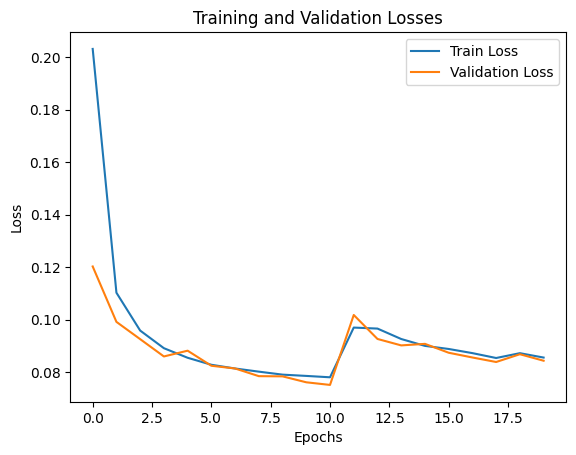

In [39]:
from matplotlib import pyplot as plt
# Plotting the losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses')
plt.show()

## 2.5 The Reverse Step

Now we need to define the reverse step $p_\theta(\mathbf{x}_{t-1} \vert \mathbf{x}_t)$

See that little $_\theta$? That often indicates 'learned parameters' - in this case our unet model! We use our model to predict the noise and then 'undo' the forward noise steps one at a time to go from an image that is pure noise to one that (hopefully) looks like a real image:

In [42]:
################################################################################


def p_xt(xt, noise, t):

    # Extract alpha_t, alpha_bar_t, and beta values using direct indexing
    alpha_t = alpha[t]
    alpha_bar_t = alpha_bar[t]

    # Compute epsilon coefficient for mean calculation
    eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** 0.5

    # Calculate the mean using the given formula (note the minus sign)
    mean = xt / alpha_t ** 0.5 - eps_coef * noise / alpha_t ** 0.5

    # Extract the variance (beta) using direct indexing
    var = beta[t]

    # Generate random noise with the same shape as xt
    eps = torch.randn_like(xt)

    # Compute the final value using the mean and scaled variance
    return mean + var ** 0.5 * eps


    # End
################################################################################


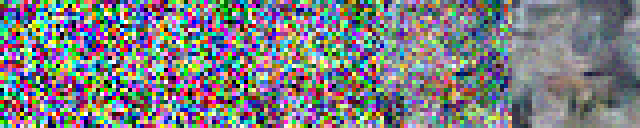

In [43]:
x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
ims = []

################################################################################

# Iterate over the range of n_steps
for i in range(n_steps):
    # Calculate the time step in reverse order
    t = torch.tensor(n_steps - i - 1, dtype=torch.long).cuda()

    # Use unet to predict noise for the current time step
    with torch.no_grad():
        pred_noise = unet(x.float(), t.unsqueeze(0))

    # Update the input data x using the predicted noise and time step
    x = p_xt(x, pred_noise, t.unsqueeze(0))

    # Append the image representation of x to ims every 24 steps
    if i % 24 == 0:
        ims.append(tensor_to_image(x.cpu()))

################################################################################

image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[:5]):
  image.paste(im, ((i%5)*32, 0))
image.resize((32*4*5, 32*4), Image.NEAREST)

Perfect? No... Oh well, let's try a few more times:

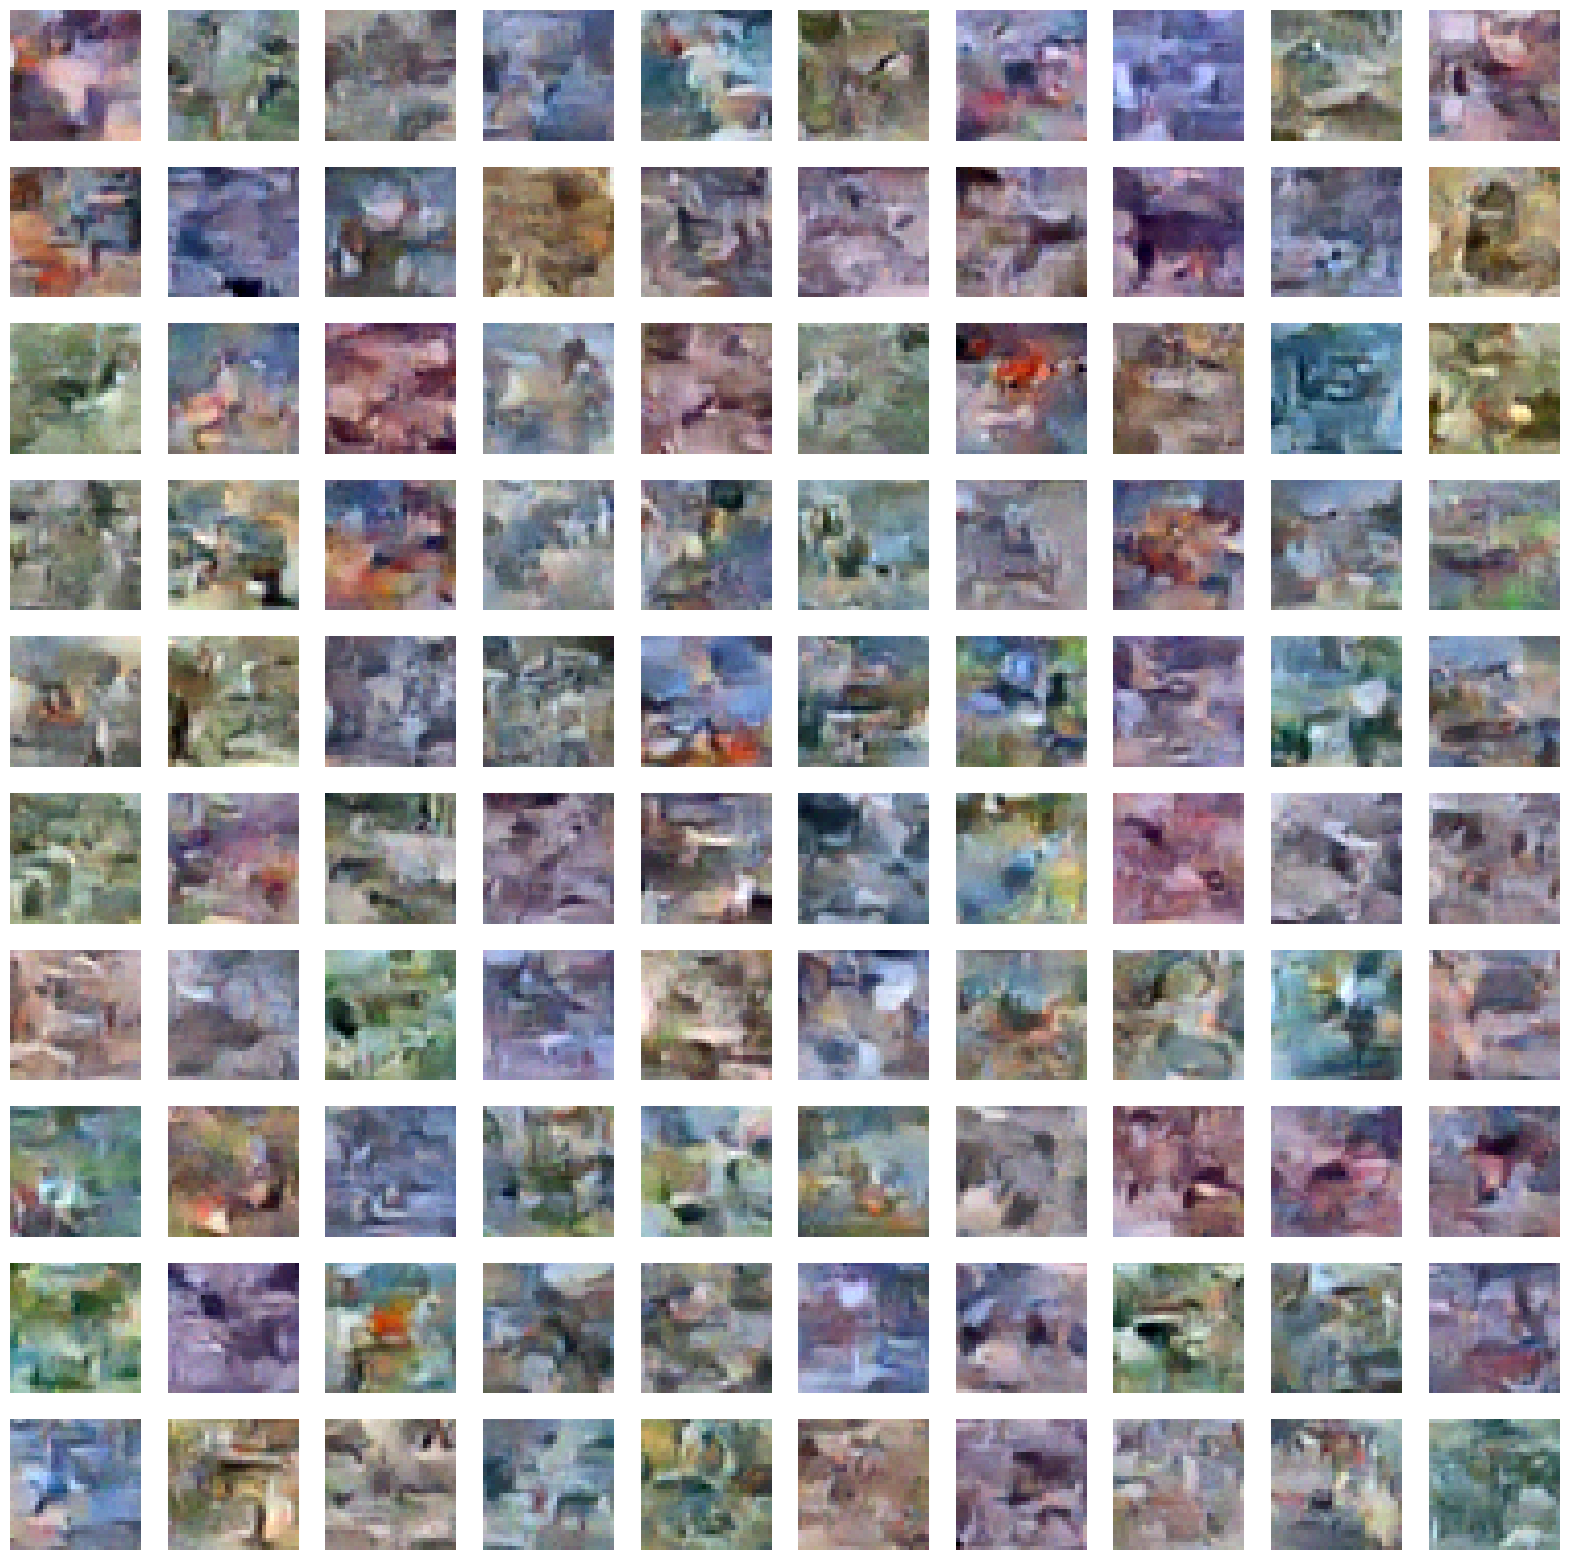

In [45]:
import matplotlib.pyplot as plt
import numpy as np

x = torch.randn(100, 3, 32, 32).cuda()
ims = []
for i in range(n_steps):
    t = torch.tensor(n_steps - i - 1, dtype=torch.long).cuda()
    with torch.no_grad():
        pred_noise = unet(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))

# Create a 10x10 grid of images
grid_size = (10, 10)
fig, axes = plt.subplots(*grid_size, figsize=(20, 20))

for i in range(grid_size[0]):
    for j in range(grid_size[1]):
        ims.append(tensor_to_image(x[i * grid_size[1] + j].unsqueeze(0).cpu()))
        axes[i, j].imshow(np.asarray(ims[-1]))
        axes[i, j].axis('off')

plt.show()




# **Part2: Evaluating the Generated Samples:**

Now we want to evaluate our model. For this, we use the FID score.

First, read [this link](https://github.com/mseitzer/pytorch-fid) to become familiar with this metric and its usage in your code.

Installation

In [46]:
!pip install pytorch-fid

Generate and Save Samples

In [47]:
from torchvision.utils import save_image
import os
from tqdm import tqdm

os.makedirs('generated_images', exist_ok=True)

# Generate and save 3000 samples
for k in tqdm(range(3000)):
    x = torch.randn(1, 3, 32, 32).cuda() # Start with random noise
    for i in range(n_steps):
        t = torch.tensor(n_steps - i - 1, dtype=torch.long).cuda()
        with torch.no_grad():
            pred_noise = unet(x.float(), t.unsqueeze(0))
            x = p_xt(x, pred_noise, t.unsqueeze(0))

    # Save each generated image with a unique filename
    save_image(x, f'content/generated_images/sample_{k}.png')

100%|██████████| 3000/3000 [1:38:27<00:00,  1.97s/it]


In [48]:
import torchvision
import torchvision.transforms as transforms

os.makedirs('cifar10_real_images', exist_ok=True)

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor()
])
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# and save 3000 real samples
for i, (image, _) in enumerate(cifar10_dataset):
    torchvision.utils.save_image(image, f'cifar10_real_images/cifar10_{i:04d}.png')
    if i >= 2999:
        break

100%|██████████| 170498071/170498071 [00:02<00:00, 83267554.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


Compute the FID Score

In [49]:
from pytorch_fid.fid_score import calculate_fid_given_paths

# Paths to the generated images and real images
path_to_generated_images = 'generated_images'
path_to_real_images = 'cifar10_real_images'

# Calculate the FID score
fid_value = calculate_fid_given_paths([path_to_generated_images, path_to_real_images],
                                      batch_size=50,
                                      device='cuda',
                                      dims=2048)
print(f'FID score: {fid_value}')

Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 208MB/s]
100%|██████████| 60/60 [00:12<00:00,  4.85it/s]


FID score: 167.20400019331666
